<a href="https://colab.research.google.com/github/so3500/2024-spark/blob/main/sungon/week3_weather.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Prepare Environment

Install Dependencies:


1.   Java 8
2.   Apache Spark with hadoop and
3.   Findspark (used to locate the spark in the system)

> If you have issues with spark version, please upgrade to the latest version from [here](https://archive.apache.org/dist/spark/).

In [1]:
### java
!apt-get install openjdk-8-jdk-headless -qq > /dev/null

### spark & pyspark
#!wget -q http://archive.apache.org/dist/spark/spark-3.5.1/spark-3.5.1-bin-hadoop3.tgz
!cp /content/drive/MyDrive/2024_pyspark/spark-3.5.1-bin-hadoop3.tgz /content/
!tar xf spark-3.5.1-bin-hadoop3.tgz
!pip install -q findspark

### test data
!cp -r /content/drive/MyDrive/2024_pyspark/weather_data /content/

Set Environment Variables:

In [2]:
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-3.5.1-bin-hadoop3"

In [3]:
import findspark
findspark.init()
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, avg, count, year, datediff, expr, min, max, filter, count_if, when, trim, to_date, month
from pyspark.sql.types import StructType, StructField, IntegerType, StringType, TimestampType, DoubleType

spark = SparkSession.builder\
  .master("local[*]")\
  .getOrCreate()
spark.conf.set("spark.sql.repl.eagerEval.enabled", True) # Property used to format output tables better
spark

In [4]:
from pyspark.sql.dataframe import DataFrame

# Define a Peek Function
def peek(self, n=10):
  self.show(n)
  return self

# Monkey Patch the DataFrame Calss
DataFrame.peek = peek

# 출제 문제 : 폭염 & 자외선 기준으로 최고체감온도 집계하기

- 2304 ~ 2309 데이터를 모두 사용합니다. (29646 건)

데이터 필터링
- 데이터를 보니 일부 컬럼이 비어있는 row 가 있습니다.
- 폭염영향예보를 제외한 컬럼이 모두 필수값이 되도록 필터링합니다.
- 필터링 후 row 는 27335개가 됩니다.

폭염일 때와 아닐때의 최고체감온도 최소/평균/최대 값을 구하세요.

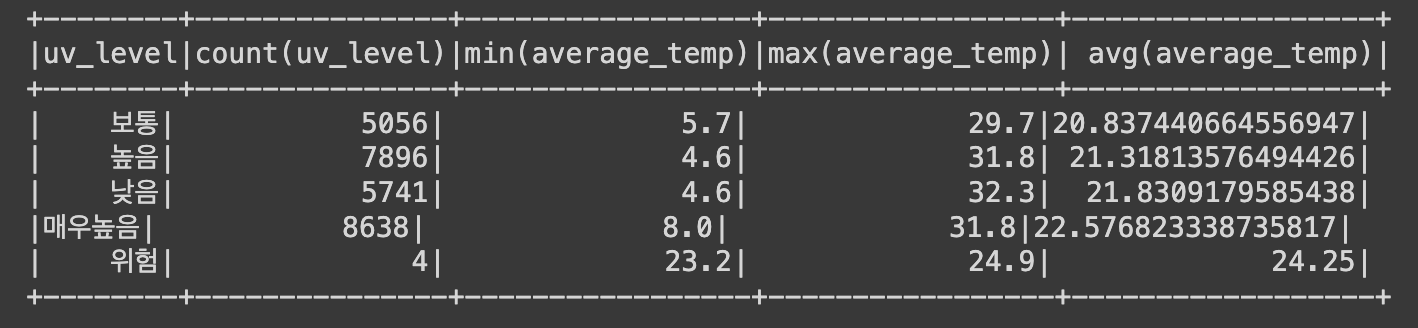

폭염특보일 때와 아닐때의 최고체감온도 최소/평균/최대 값을 구하세요.
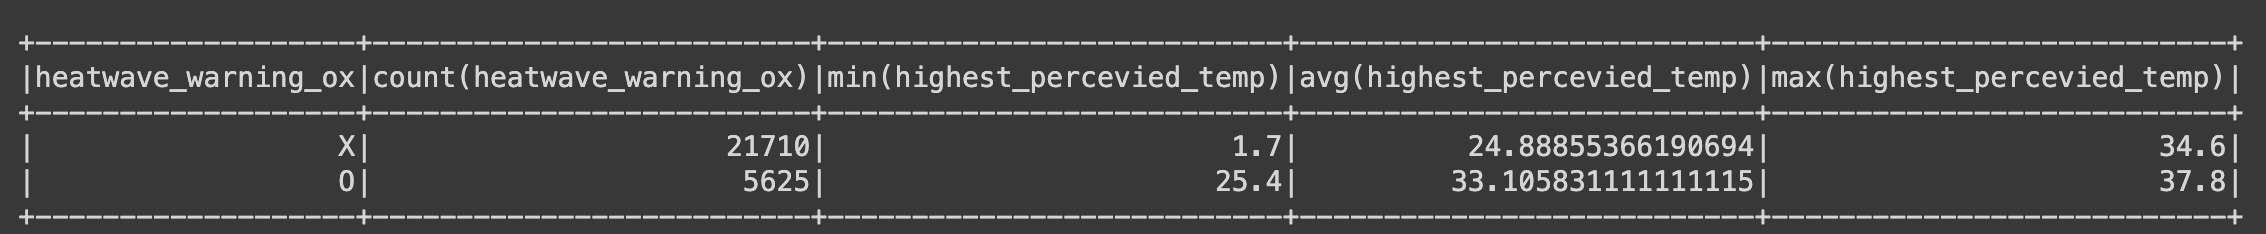

폭염영향예보 단계별 최고체감온도 최소/평균/최대 값을 구하세요.
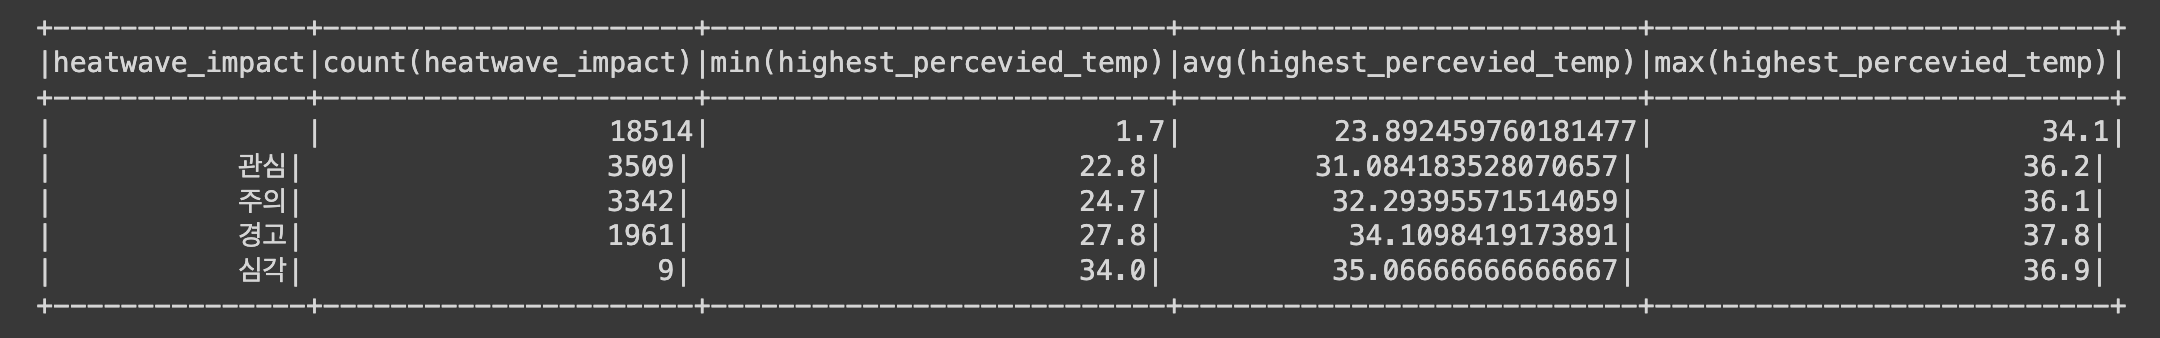

자외선 지수 단계 별 온도의 최소, 최대, 평균값을 구합니다.
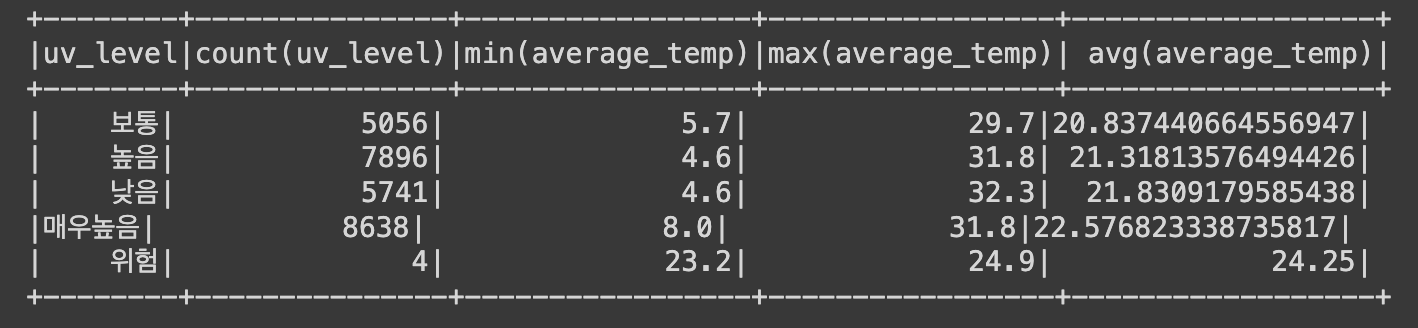

In [7]:
weather_lables = [
    ('date', StringType()),
    ('location', StringType()),
    ('heatwave_ox', StringType()),
    ('highest_percevied_temp', DoubleType()),
    ('highest_temp', DoubleType()),
    ('average_temp', DoubleType()),
    ('lowest_temp', DoubleType()),
    ('average_rhm', DoubleType()),
    ('heatwave_warning_ox', StringType()),
    ('heatwave_impact', StringType()),
    ('tropical_ox', StringType()),
    ('uv_level', StringType()),
]
weather_schema = StructType([StructField(x[0], x[1], True) for x in weather_lables])
# 디렉토리 경로를 넘길 경우 한번에 파일을 읽을 수 있음 (각 df 생성 후 join 할 필요 없음)
weather_df = spark.read.csv('weather_data/', header=True, sep=",", schema=weather_schema).withColumn('date', to_date('date', 'yyyy.M.d'))

print(f'before filtereing weather_df.count(): {weather_df.count()}')

# weather_df.dropna 를 사용할 수도 있다.
# 각 컬럼 별 값이 없는 경우는 모두 필터링
weather_df = weather_df.filter(weather_df.heatwave_ox.isNotNull())\
  .filter(weather_df.highest_percevied_temp.isNotNull())\
  .filter(weather_df.highest_temp.isNotNull())\
  .filter(weather_df.average_temp.isNotNull())\
  .filter(weather_df.lowest_temp.isNotNull())\
  .filter(weather_df.average_rhm.isNotNull())\
  .filter(weather_df.heatwave_warning_ox.isNotNull())\
  .filter(weather_df.heatwave_impact.isNotNull())\
  .filter(weather_df.tropical_ox.isNotNull())\
  .filter(weather_df.uv_level.isNotNull())

print(f'after filtereing weather_df.count(): {weather_df.count()}')

from pyspark.sql.functions import year, month, percentile, max, min, rank

# 폭염일 때와 아닐때의 최고체감온도 최소/평균/최대 값을 구하세요.
weather_df.groupBy('heatwave_ox')\
  .agg(count('heatwave_ox'), min('highest_percevied_temp'), avg('highest_percevied_temp'), max('highest_percevied_temp'))\
  .show()

# 폭염특보일 때와 아닐때의 최고체감온도 최소/평균/최대 값을 구하세요.
weather_df.groupBy('heatwave_warning_ox')\
  .agg(count('heatwave_warning_ox'), min('highest_percevied_temp'), avg('highest_percevied_temp'), max('highest_percevied_temp'))\
  .show()

# 폭염영향예보 단계별 최고체감온도 최소/평균/최대 값을 구하세요.
weather_df.groupBy('heatwave_impact')\
  .agg(count('heatwave_impact'), min('highest_percevied_temp'), avg('highest_percevied_temp'), max('highest_percevied_temp'))\
  .show()

# 자외선 지수 단계 별 온도의 최소, 최대, 평균값을 구합니다.
weather_df.groupBy('uv_level')\
  .agg(count('uv_level'), min('average_temp'), max('average_temp'), avg('average_temp'))\
  .orderBy(avg('average_temp'))\
  .show()

before filtereing weather_df.count(): 59292
after filtereing weather_df.count(): 27335
+-----------+------------------+---------------------------+---------------------------+---------------------------+
|heatwave_ox|count(heatwave_ox)|min(highest_percevied_temp)|avg(highest_percevied_temp)|max(highest_percevied_temp)|
+-----------+------------------+---------------------------+---------------------------+---------------------------+
|          O|              3302|                       33.0|         34.159721380981296|                       37.8|
|          X|             24033|                        1.7|         25.538026879707065|                       32.9|
+-----------+------------------+---------------------------+---------------------------+---------------------------+

+-------------------+--------------------------+---------------------------+---------------------------+---------------------------+
|heatwave_warning_ox|count(heatwave_warning_ox)|min(highest_percevied_temp)|a

# 과제풀이

데이터셋 준비

In [23]:
weather_lables = [
    ('date', StringType()),
    ('location', StringType()),
    ('heatwave_ox', StringType()),
    ('highest_percevied_temp', DoubleType()),
    ('highest_temp', DoubleType()),
    ('average_temp', DoubleType()),
    ('lowest_temp', DoubleType()),
    ('average_rhm', DoubleType()),
    ('heatwave_warning_ox', StringType()),
    ('heatwave_impact', StringType()),
    ('tropical_ox', StringType()),
    ('uv_level', StringType()),
]
weather_schema = StructType([StructField(x[0], x[1], True) for x in weather_lables])
weather_df = spark.read.csv('weather_data/', header=True, sep=",", schema=weather_schema).withColumn('date', to_date('date', 'yyyy.M.d'))

## 문제1. 자외선지수와 온도, 습도와의 상관관계 분석 by 이태용님
https://github.com/LandvibeDev/2024-spark/pull/9

문제설명:

1. 일별로 평균최고온도, 평균상대습도, 평균자외선 지수를 구한다. [바로 아래 예시 참고]

> ※ 자외선지수는 기상정보에 따라 다음과 같이 수치화한다.
> "낮음": 1.5, "보통": 4.5, "높음": 7, "매우높음": 9.5, "위험": 13

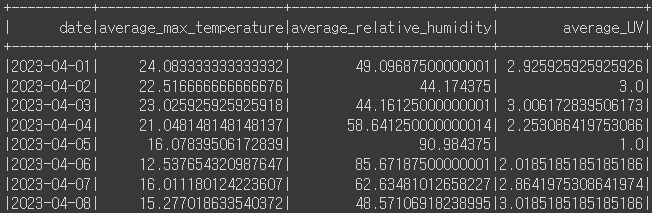

2. average_max_temperature의 평균 값보다 높은 행들 필터링, 낮은 행들 각각 필터링

3. 필터링된 두 dataframe의 average_UV값을 비교 => 온도파트 끝

4. average_relative_humidity의 평균 값보다 높은 행들 필터링, 낮은 행들 필터링

5. 필터링된 두 dataframe의 average_UV값을 비교 => 습도파트 끝

출력 결과 예시 :

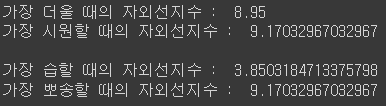

In [ ]:
from pyspark.sql.functions import lit, udf

# prepare
p1_weather_df = weather_df

# define udf & add uv column
uv_level_to_number_dic = {
    '낮음': 1.5,
    '보통': 4.5,
    '높음': 7.0,
    '매우높음': 9.5,
    '위험': 13.0,
}
uv_level_to_number_udf = udf(lambda x: uv_level_to_number_dic.get(x, 0.0), DoubleType())
p1_weather_df = p1_weather_df.withColumn('uv', uv_level_to_number_udf(p1_weather_df.uv_level))

# problem 1-1
p1_weather_avg_df = p1_weather_df.groupBy('date').agg(
    avg('highest_temp').alias('average_max_temperature'),
    avg('average_rhm').alias('average_relative_humidity'),
    avg('uv').alias('average_uv')
).orderBy('date')
p1_weather_avg_df.show(10)

+----------+-----------------------+-------------------------+------------------+
|      date|average_max_temperature|average_relative_humidity|        average_uv|
+----------+-----------------------+-------------------------+------------------+
|2023-04-01|     23.661702127659574|        50.42127659574467| 6.787234042553192|
|2023-04-02|     22.282352941176473|        46.30392156862743|               7.0|
|2023-04-03|     22.816822429906537|        46.24018691588784|               7.0|
|2023-04-04|     20.872857142857146|        62.52142857142856| 5.178571428571429|
|2023-04-05|     15.937894736842114|        91.69263157894736|               1.5|
|2023-04-06|     11.559541984732817|         88.5679389312977|               4.5|
|2023-04-07|      16.03924050632912|        62.63481012658227| 6.667721518987341|
|2023-04-08|     15.290506329113928|        48.60632911392406|7.0474683544303796|
|2023-04-09|     18.770344827586218|        51.46551724137931| 7.051724137931035|
|2023-04-10|    

In [ ]:
# problem 1-2 ~ 1-5

# Exract the numeric value from the DataFrame
avg_of_avg_max_temp = p1_weather_df.agg(avg('highest_temp')).collect()[0][0]
avg_of_avg_rh = p1_weather_df.agg(avg('average_rhm')).collect()[0][0]

uv_when_hot = p1_weather_avg_df\
  .filter(p1_weather_avg_df.average_max_temperature > avg_of_avg_max_temp)\
  .peek(5)\
  .agg(avg('average_uv'))\
  .collect()[0][0]
uv_when_cool = p1_weather_avg_df\
  .filter(p1_weather_avg_df.average_max_temperature < avg_of_avg_max_temp)\
  .peek(5)\
  .agg(avg('average_uv'))\
  .collect()[0][0]
print(f'가장 더울 때의 자외선 지수 : {uv_when_hot}\n가장 시원할 때의 자외선 지수 : {uv_when_cool}\n')

uv_when_humid = p1_weather_avg_df\
  .filter(p1_weather_avg_df.average_relative_humidity > avg_of_avg_rh)\
  .peek(5)\
  .agg(avg('average_uv'))\
  .collect()[0][0]

uv_when_soft = p1_weather_avg_df\
  .filter(p1_weather_avg_df.average_relative_humidity < avg_of_avg_rh)\
  .peek(5)\
  .agg(avg('average_uv'))\
  .collect()[0][0]
print(f'가장 습할 때의 자외선 지수 : {uv_when_humid}\n가장 뽀송할 때의 자외선 지수 : {uv_when_soft}')

+----------+-----------------------+-------------------------+-----------------+
|      date|average_max_temperature|average_relative_humidity|       average_uv|
+----------+-----------------------+-------------------------+-----------------+
|2023-05-15|     27.204347826086966|       63.973584905660374|9.484567901234568|
|2023-05-16|      30.65740740740739|                59.939375|              9.5|
|2023-05-17|      29.40802469135801|        62.33874999999999|9.438271604938272|
|2023-05-31|      26.81049382716049|                    66.32|8.203703703703704|
|2023-06-02|     26.946296296296293|         74.5616352201258|8.697530864197532|
+----------+-----------------------+-------------------------+-----------------+
only showing top 5 rows

+----------+-----------------------+-------------------------+-----------------+
|      date|average_max_temperature|average_relative_humidity|       average_uv|
+----------+-----------------------+-------------------------+-----------------+
|20

## 문제2. 서울의 기온과 폭염특보의 관계 비교 by 박수지님

문제 설명 : 서울(108)의 월별 평균기온과 폭염특보가 뜬 개수를 구해 1개월 단위로 비교하십시오.

지역 : 서울

1. 2023년 4~9월 테이블을 사용합니다.
2. 해당 지역의 최고기온, 평균기온, 최저기온의 각 평균을 구해 분석합니다.
3. 해당 지역에 한 달간 폭염특보가 내려진 횟수를 계산합니다.
4. 폭염특보의 횟수가 높은 순서로 결과를 정렬합니다. 횟수가 동일할 경우 평균기온이 높은 순서대로 정렬합니다.

- 편의를 위해 임의로 month 열을 추가하였습니다!

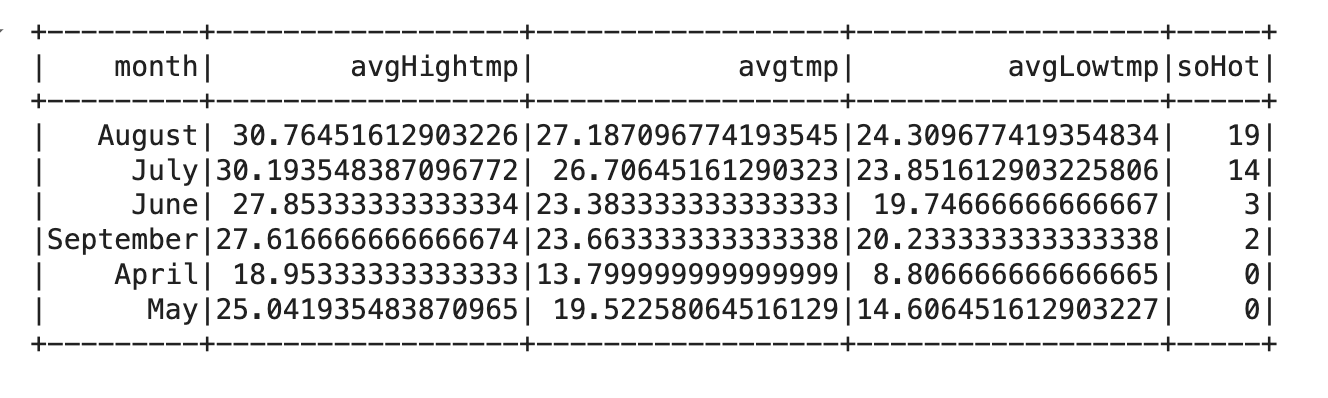




In [22]:
# prepare dataset
weather_lables = [
    ('date', StringType()), # TimestampType() 변환필요
    ('location', StringType()),
    ('heatwave_ox', StringType()),
    ('highest_percevied_temp', DoubleType()),
    ('highest_temp', DoubleType()),
    ('average_temp', DoubleType()),
    ('lowest_temp', DoubleType()),
    ('average_rhm', DoubleType()),
    ('heatwave_warning_ox', StringType()),
    ('heatwave_impact', StringType()),
    ('tropical_ox', StringType()),
    ('uv_level', StringType())
]
weather_schema = StructType([StructField(x[0], x[1], True) for x in weather_lables])
p2_weather_df = spark.read.csv('weather_data/', header=True, sep=",", schema=weather_schema).withColumn('date', to_date('date', 'yyyy.M.d'))

# solve problem
from pyspark.sql.functions import date_format

p2_weather_df = weather_df.filter('location == "서울(108)"')\
  .withColumn('month', date_format(col('date'), 'MMMM'))

p2_weather_df\
  .groupBy('month')\
  .agg(
      avg('highest_temp').alias('avg_high_temp'),
      avg('average_temp').alias('avg_temp'),
      avg('lowest_temp').alias('avg_low_temp'),
      count_if(col('heatwave_warning_ox') == "O").alias('so_hot')
  )\
  .orderBy('so_hot', ascending=False)\
  .show()

+---------+------------------+------------------+------------------+------+
|    month|     avg_high_temp|          avg_temp|      avg_low_temp|so_hot|
+---------+------------------+------------------+------------------+------+
|   August| 30.76451612903226|27.187096774193545|24.309677419354834|    19|
|     July|30.193548387096772| 26.70645161290323|23.851612903225806|    14|
|     June| 27.85333333333334|23.383333333333333| 19.74666666666667|     3|
|September|27.616666666666674|23.663333333333338|20.233333333333338|     2|
|      May|25.041935483870965| 19.52258064516129|14.606451612903227|     0|
|    April|16.847368421052632|11.999999999999998|7.0473684210526315|     0|
+---------+------------------+------------------+------------------+------+



## 문제3. 매월마다 폭염특보가 가장 많이 발효된 지역 찾기 by 고승빈님

매월(month)마다 폭염특보가 가장 많이 발효된 지역(ex. 북강릉(104))을 찾아봅시다.

각 월마다 폭염특보가 발효된 카운트가 동일하다면, 지역명이 내림차순했을때 가장 첫 번째 지역을 필터링합니다. (ex. 8월에 폭염특보가 "강원", "대구", "부산"이 각각 6번 발효되었다면, "강원"으로 지정합니다.)

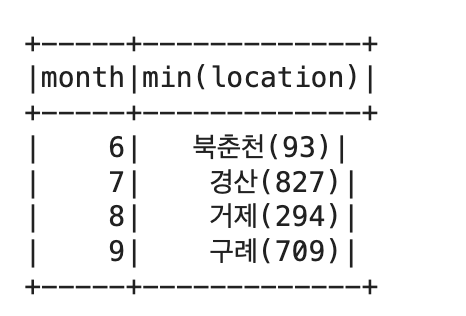

OR

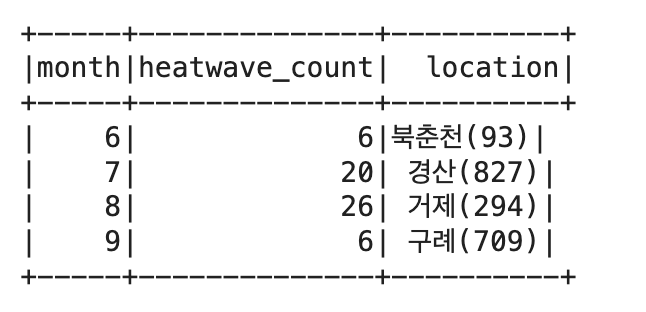

In [16]:
from pyspark.sql.functions import row_number
from pyspark.sql.window import Window

windowSpec = Window.partitionBy('month').orderBy(col('heatwave_warning_count').desc())

p3_weather_df = weather_df.withColumn('month', month('date'))\
  .groupby('month', 'location')\
  .agg(count_if(col('heatwave_warning_ox') == 'O').alias('heatwave_warning_count'))\
  .filter(col('heatwave_warning_count') > 0)\
  .orderBy('location')\
  .withColumn('rank', row_number().over(windowSpec))\
  .filter(col('rank') == 1)\
  .show()

+----------+-----------+-----------+----------------------+------------+------------+-----------+-----------+-------------------+---------------+-----------+--------+-----+
|      date|   location|heatwave_ox|highest_percevied_temp|highest_temp|average_temp|lowest_temp|average_rhm|heatwave_warning_ox|heatwave_impact|tropical_ox|uv_level|month|
+----------+-----------+-----------+----------------------+------------+------------+-----------+-----------+-------------------+---------------+-----------+--------+-----+
|2023-08-01|북강릉(104)|          X|                  31.8|        31.4|        27.0|       22.8|       78.6|                  O|           경고|          O|    낮음|    8|
|2023-08-01|  동해(106)|          X|                  30.6|        30.0|        26.2|       22.8|       86.5|                  O|           주의|          O|    낮음|    8|
|2023-08-01|  서울(108)|          O|                  34.6|        34.2|        29.9|       25.5|       71.6|                  O|           경고|       

## 문제4. 대한민국 행정구역별 평균 온도 분석 by 박준영님

https://github.com/LandvibeDev/2024-spark/pull/12

다음은 지점 테이블의 지점 번호를 행정 구역별로 정리한 것입니다.(ex,충주(127))

- 4월부터 9월까지의 데이터를 사용합니다.
- 행정구역과 평균 온도의 평균을 기준으로 분석합니다.
- 행정구역별 평균 온도의 평균이 높은 순서로 결과를 정렬합니다.

결과예시

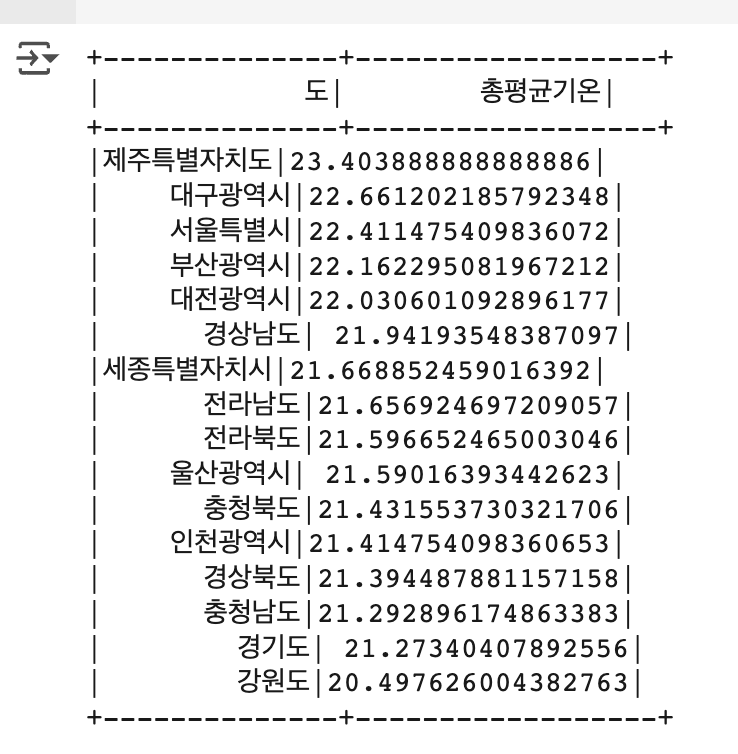

In [ ]:
regions = {
    "서울특별시": ["108"],
    "인천광역시": ["112"],
    "부산광역시": ["159"],
    "대구광역시": ["143"],
    "대전광역시": ["133"],
    "울산광역시": ["152"],
    "세종특별자치시": ["239"],
    "경기도": [
        119, 202, 203, 551, 549, 434, 433, 437, 438, 441, 444, 445,
        505, 504, 516, 532, 540, 541, 545, 546, 548, 550, 555, 556,
        565, 569, 571, 572, 590, 598, 601, 602, 603, 604
    ],
    "강원도": [
        104, 106, 114, 115, 121, 211, 212, 216, 217, 526, 555, 556,
        606, 90, 876, 93
    ],
    "충청북도": [127, 131, 221, 226, 601, 602, 603, 604],
    "충청남도": [
        129, 235, 236, 238, 232, 612, 615, 616, 618, 619, 627, 628,
        634, 636
    ],
    "전라북도": [140, 146, 702, 245, 247, 248, 254, 734, 737],
    "전라남도": [
        165, 168, 169, 170, 172, 712, 713, 730, 731, 732, 706, 709,
        710, 741, 754, 768, 789, 259, 260, 261, 262
    ],
    "경상북도": [
        135, 136, 137, 138, 271, 272, 273, 276, 277, 278, 279, 281,
        283, 284, 285, 288, 289, 294, 295, 801, 810, 812, 813, 815,
        822, 823, 825, 827
    ],
    "경상남도": [155, 162, 192, 253, 257, 264, 263, 268, 920],
    "제주특별자치도": ["184"]
}


# create reverse mapping dictionary (지역코드 key, 지역명 value)
regions_by_code = {value: key for key, value_list in regions.items() for value in value_list}
print(regions_by_code)

# convert key type to integer
regions_by_code = {int(key): value for key, value in regions_by_code.items()}
print(regions_by_code)

import re
# location : 북강릉(104)
def get_region(location):
  print(location)
  region_code_match = re.search(r'\((\d+)\)', location)
  if region_code_match:
    region_code = int(region_code_match.group(1))
    return regions_by_code.get(region_code, '해당없음')

# udf function wrpas `get_region` function to make it compatitable with Spark DateFrames
get_region_udf = udf(get_region, StringType())

# 예시 결과와 동일하나 일부 지역이 region 에 매핑되지 않은 것으로 보임
p5_weather_df = weather_df.withColumn('region', get_region_udf(weather_df['location']))
p5_weather_df.withColumn('region', get_region_udf(p5_weather_df['location']))\
  .groupBy('region')\
  .agg(avg('average_temp').alias('총평균기온'))\
  .orderBy('총평균기온', ascending=False)\
  .show()

# 이 지역을 region 에 반영 후 통계 돌리면 다른 데이터가 나올 것임
p5_weather_df.filter('region = "해당없음"').groupBy('location').count().show();

{'108': '서울특별시', '112': '인천광역시', '159': '부산광역시', '143': '대구광역시', '133': '대전광역시', '152': '울산광역시', '239': '세종특별자치시', 119: '경기도', 202: '경기도', 203: '경기도', 551: '경기도', 549: '경기도', 434: '경기도', 433: '경기도', 437: '경기도', 438: '경기도', 441: '경기도', 444: '경기도', 445: '경기도', 505: '경기도', 504: '경기도', 516: '경기도', 532: '경기도', 540: '경기도', 541: '경기도', 545: '경기도', 546: '경기도', 548: '경기도', 550: '경기도', 555: '강원도', 556: '강원도', 565: '경기도', 569: '경기도', 571: '경기도', 572: '경기도', 590: '경기도', 598: '경기도', 601: '충청북도', 602: '충청북도', 603: '충청북도', 604: '충청북도', 104: '강원도', 106: '강원도', 114: '강원도', 115: '강원도', 121: '강원도', 211: '강원도', 212: '강원도', 216: '강원도', 217: '강원도', 526: '강원도', 606: '강원도', 90: '강원도', 876: '강원도', 93: '강원도', 127: '충청북도', 131: '충청북도', 221: '충청북도', 226: '충청북도', 129: '충청남도', 235: '충청남도', 236: '충청남도', 238: '충청남도', 232: '충청남도', 612: '충청남도', 615: '충청남도', 616: '충청남도', 618: '충청남도', 619: '충청남도', 627: '충청남도', 628: '충청남도', 634: '충청남도', 636: '충청남도', 140: '전라북도', 146: '전라북도', 702: '전라북도', 245: '전라북도', 247: '전라북도', 248: '전라